![Machine Learning Lab](banner.jpg)


# Laboratorio 4 Actividad


## Instrucciones generales


1. Esta actividad debe ser entregada por BN y es de carácter individual. No se permite entregar el laboratorio después de la fecha establecida.
2. Al responder las preguntas de las actividades por favor marcar las respuestas con la sección a la que corresponden, por ejemplo: `## Exploración de datos 2.1`. Es preferible que esto lo hagan con secciones de MarkDown.
3. Por favor nombrar el archivo de acuerdo al siguiente formato `{email}_lab4.ipynb`.
4. Si tienen alguna duda pueden escribirme a mi correo `j.rayom@uniandes.edu.co` o contactarme directamente por Teams

Para este laboratorio deben usar el siguiente dataset de Telco Customer Churn: `https://www.kaggle.com/datasets/mosapabdelghany/telcom-customer-churn-dataset`

* * *

Instrucciones
-------------

### 0\. Descarga del Dataset

Utiliza el siguiente enlace para descargar el dataset de Telco Customer Churn desde Kaggle:

[Descargar Dataset](https://www.kaggle.com/datasets/mosapabdelghany/telcom-customer-churn-dataset)

El dataset contiene información de clientes de una empresa de telecomunicaciones y su comportamiento de abandono (churn). En este laboratorio nuestra variable objetivo será la columna `Churn`.

### 1\. Exploración de datos (5%)

1. Carga el dataset en un DataFrame de pandas.
2. Analiza la distribución de la variable objetivo `Churn` y crea una visualización con un gráfico de barras.

### 2\. Preprocesamiento de Datos (15%)

1. **Limpieza de datos**: Convierte la columna `TotalCharges` a numérico y maneja los valores nulos reemplazándolos por `MonthlyCharges * tenure`.
2. **Eliminar columna irrelevante**: Remueve la columna `customerID`.
3. **Separación de variables**: Separa las características (X) de la variable objetivo (y = `Churn`).
4. **División train/test**: Divide los datos en conjuntos de entrenamiento y prueba usando `train_test_split` con `test_size=0.2`, `random_state=42` y `stratify=y`.
5. **Pipeline de preprocesamiento**: Crea pipelines separados para variables numéricas (con `SimpleImputer` y `StandardScaler`) y categóricas (con `SimpleImputer` y `OneHotEncoder`), luego combínalos con `ColumnTransformer`.

### 3\. Entrenamiento de modelo (60%)

Para cada uno de los siguientes modelos `DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, XGBClassifier` realizar los siguientes pasos:

1. **Entrenar el modelo**: Ajusta cada modelo usando los datos de entrenamiento preprocesados. Usa `LabelEncoder` para convertir las etiquetas categóricas a numérica.
2. **Matriz de confusión**: Grafica la matriz de confusión del modelo.
3. **Reporte de clasificación**: Genera y muestra el reporte de clasificación.
4. **Análisis SHAP**: Grafica los valores SHAP para interpretar la importancia de las variables (Excluyendo AdaBoostClassifier).
5. **Árbol de decisión**: Para `DecisionTreeClassifier`, grafica los primeros 3 niveles del árbol.
6. **Importancia de variables**: ¿Cuales son las dos variables más importantes para esta tarea de clasificación según los resultados obtenidos? Justifique su respuesta.


### 4\. Gráfica de frontera de decisiones (20%)

1. **Visualización de fronteras**: Usa la función `plot_class_boundaries` presentada abajo para graficar las fronteras de decisión de un `DecisionTreeClassifier` y un `RandomForestClassifier`. Utiliza las dos variables numéricas más importantes identificadas en el punto anterior con valores de `max_depth` de `3, 10, 100`.

¿Qué diferencias observa entre usar `max_depth=3`, `max_depth=10` y `max_depth=100`? ¿Cómo cree que esto afecte el overfitting? Analice las fronteras de decisión y la estructura del árbol.


In [17]:
from sklearn.tree import plot_tree, DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import kagglehub
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from ydata_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def generate_palette(n, cmap_name='viridis'):
    cmap = cm.get_cmap(cmap_name, n)
    return [mcolors.to_hex(cmap(i)) for i in range(n)]


def plot_class_boundaries(X_train_processed, y_train, column_1, column_2, model_class, **model_kwargs):
    """
    Grafica las fronteras de decisión de un modelo de clasificación basado en dos características
    seleccionadas de los datos de entrenamiento. Esta función ajusta el modelo dado en las
    columnas de características proporcionadas y visualiza las regiones de decisión, fronteras
    de clase y puntos de entrenamiento en un gráfico 2D.

    :param X_train_processed: DataFrame que contiene los datos de entrenamiento procesados.
    :param y_train: Las etiquetas objetivo correspondientes a los datos de entrenamiento.
    :param column_1: El nombre de la primera columna de características para graficar fronteras.
    :param column_2: El nombre de la segunda columna de características para graficar fronteras.
    :param model_class: La clase de clasificador a instanciar para ajuste y visualización.
    :param model_kwargs: Argumentos adicionales para inicializar la instancia del clasificador.
    :return: None
    """
    # Extraer solo las dos columnas especificadas
    X_train_selected = X_train_processed[[column_1, column_2]].values

    # Codificar y_train a binario para la visualización
    y_train_binary = (y_train == 'Yes').astype(int)

    # Entrenar el modelo
    model = model_class(**model_kwargs)
    model.fit(X_train_selected, y_train_binary)

    # Generar una malla de puntos
    x_min, x_max = X_train_selected[:, 0].min() - 1, X_train_selected[:, 0].max() + 1
    y_min, y_max = X_train_selected[:, 1].min() - 1, X_train_selected[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Predecir en la malla
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Generar paleta de colores
    # Configurar colores
    colors = ['lightblue', 'lightcoral']
    cmap = ListedColormap(colors)

    # Graficar fronteras de decisión
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)

    # Graficar puntos de entrenamiento
    scatter = plt.scatter(X_train_selected[:, 0], X_train_selected[:, 1], c=y_train_binary, cmap=cmap, edgecolor='k')

    # Etiquetas y título
    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.title(f'Fronteras de Decisión usando {model_class.__name__}')

    # Agregar leyenda
    handles, labels = scatter.legend_elements()
    plt.legend(handles, labels, title="Clases")
    plt.show()

    if model_class == DecisionTreeClassifier:
        # graficar la estructura del árbol
        plt.figure(figsize=(15, 10))
        plot_tree(model, filled=True, feature_names=[column_1, column_2], 
                 class_names=['No Churn', 'Churn'], fontsize=10)
        plt.title(f'Estructura del Árbol - {model_kwargs}', fontsize=14)
        plt.tight_layout()
        plt.show()

### 0. Descarga del dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("mosapabdelghany/telcom-customer-churn-dataset")

print("Path to dataset files:", path)

100%|██████████| 172k/172k [00:00<00:00, 1.26MB/s]

Extracting files...
Path to dataset files: /Users/estefanialaverdebecerra/.cache/kagglehub/datasets/mosapabdelghany/telcom-customer-churn-dataset/versions/1


### 1\. Exploración de datos (5%)

1. Carga el dataset en un DataFrame de pandas.
2. Analiza la distribución de la variable objetivo `Churn` y crea una visualización con un gráfico de barras.

In [19]:
df_churn = pd.read_csv("datasets/Telco_Cusomer_Churn.csv")
df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


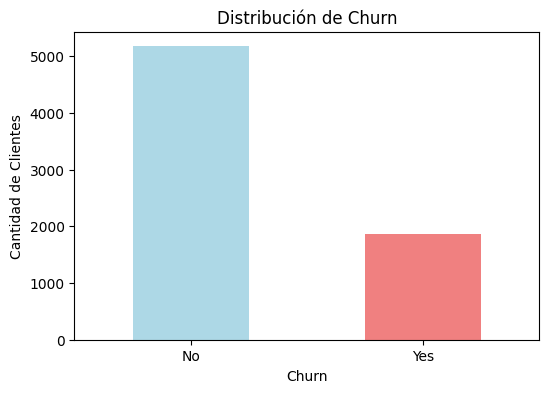

In [20]:
# analizamos la variable objetivo churn con un grafico de barras
churn_counts = df_churn['Churn'].value_counts()

plt.figure(figsize=(6, 4))
churn_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Distribución de Churn')
plt.xlabel('Churn')
plt.ylabel('Cantidad de Clientes')
plt.xticks(rotation=0)
plt.show()

Con el gráfico de barras se puede observar que aproximadamente 5000 clientes no abandonaron el servicio, mientras que alrededor de 2000 si lo hicieron. Esto indica que es una clase desbalanceada, lo que podría afectar el rendimiento de los modelos de clasificación.

### 2\. Preprocesamiento de Datos (15%)

1. **Limpieza de datos**: Convierte la columna `TotalCharges` a numérico y maneja los valores nulos reemplazándolos por `MonthlyCharges * tenure`.
2. **Eliminar columna irrelevante**: Remueve la columna `customerID`.
3. **Separación de variables**: Separa las características (X) de la variable objetivo (y = `Churn`).
4. **División train/test**: Divide los datos en conjuntos de entrenamiento y prueba usando `train_test_split` con `test_size=0.2`, `random_state=42` y `stratify=y`.
5. **Pipeline de preprocesamiento**: Crea pipelines separados para variables numéricas (con `SimpleImputer` y `StandardScaler`) y categóricas (con `SimpleImputer` y `OneHotEncoder`), luego combínalos con `ColumnTransformer`.

In [21]:
#1. limpieza de TotalCharges
df_churn['TotalCharges'] = pd.to_numeric(df_churn['TotalCharges'], errors = "coerce") # convertir a numérico, si hay errores se ponen en nan
df_churn['TotalCharges'].fillna(df_churn['MonthlyCharges'] * df_churn['tenure'], inplace=True) # rellenar los nan con monthlycharges * tenure

#2. eliminar customerID
df_churn.drop(columns=['customerID'], inplace=True)

#3. separar X y Y
X = df_churn.drop(columns=['Churn'])
y = df_churn['Churn']

#4. Dividir train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #NOTA: stratify=y se usa para mantener la misma proporción de clases en train y test, ya que el dataset está desbalanceado.

#5. pipelines para variables numéricas y categóricas
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(include=['number']).columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

# preprocesar
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

num_col_names = numerical_features.tolist()
encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_col_names = encoder.get_feature_names_out(categorical_features).tolist()
final_column_names = num_col_names + cat_col_names

X_train_processed = pd.DataFrame(X_train_processed, columns=final_column_names)
X_test_processed = pd.DataFrame(X_test_processed, columns=final_column_names)


### 3\. Entrenamiento de modelo (60%)

Para cada uno de los siguientes modelos `DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, XGBClassifier` realizar los siguientes pasos:

1. **Entrenar el modelo**: Ajusta cada modelo usando los datos de entrenamiento preprocesados. Usa `LabelEncoder` para convertir las etiquetas categóricas a numérica.
2. **Matriz de confusión**: Grafica la matriz de confusión del modelo.
3. **Reporte de clasificación**: Genera y muestra el reporte de clasificación.
4. **Análisis SHAP**: Grafica los valores SHAP para interpretar la importancia de las variables (Excluyendo AdaBoostClassifier).
5. **Árbol de decisión**: Para `DecisionTreeClassifier`, grafica los primeros 3 niveles del árbol.
6. **Importancia de variables**: ¿Cuales son las dos variables más importantes para esta tarea de clasificación según los resultados obtenidos? Justifique su respuesta.